# BTC Analysis - Statistical & ML

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sb
sb.set_style('darkgrid')

C:\Users\William\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Statistical Analysis

In [2]:
coinbase = pd.read_csv('coindesk-bpi-USD-close_data-2010-07-18_2018-01-31.csv')

In [3]:
coinbase.head()

,Date,Close Price
0,2010-07-18 00:00:00,0.09
1,2010-07-19 00:00:00,0.08
2,2010-07-20 00:00:00,0.07
3,2010-07-21 00:00:00,0.08
4,2010-07-22 00:00:00,0.05


In [4]:
coinbase['Date'] = coinbase['Date'].convert_objects(convert_dates='coerce')  
coinbase = coinbase.sort_index(by='Date')  
coinbase = coinbase.set_index('Date')  

C:\Users\William\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.
C:\Users\William\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


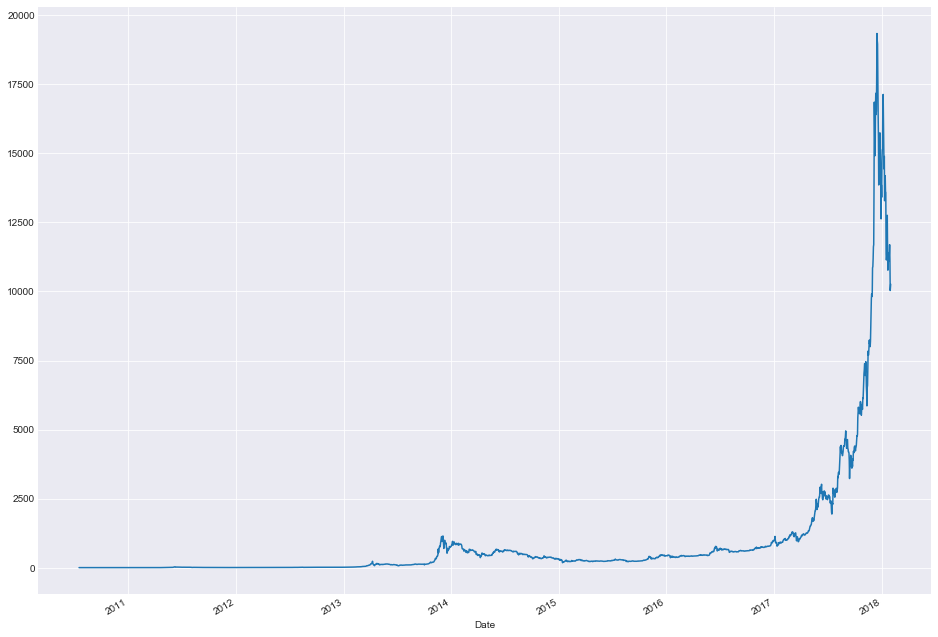

In [5]:
coinbase['Close Price'].plot(figsize=(12,10))

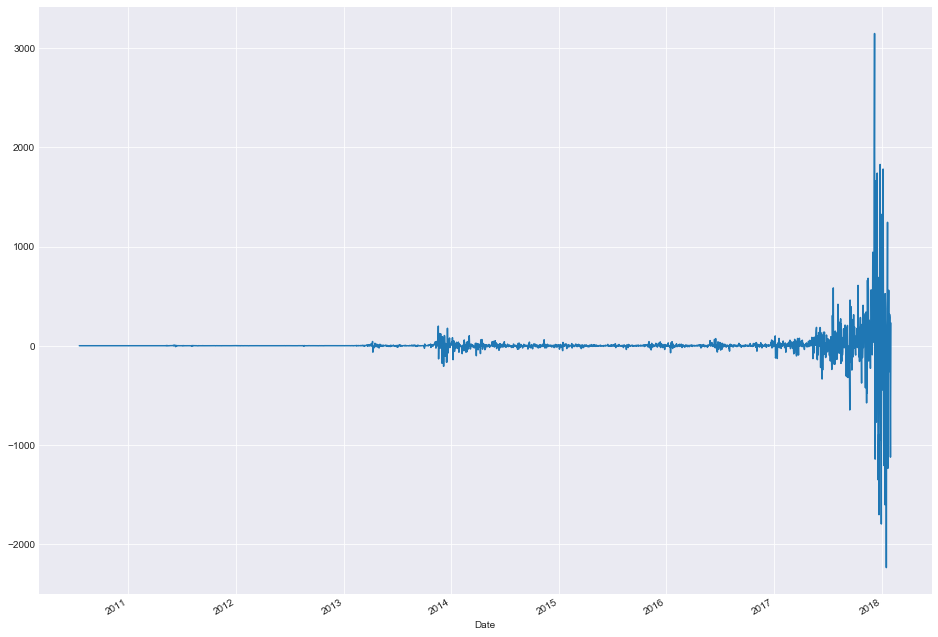

In [6]:
coinbase['First Difference'] = coinbase['Close Price'] - coinbase['Close Price'].shift()
coinbase['First Difference'].plot(figsize=(12,10))

Apply log transformation to refine changes

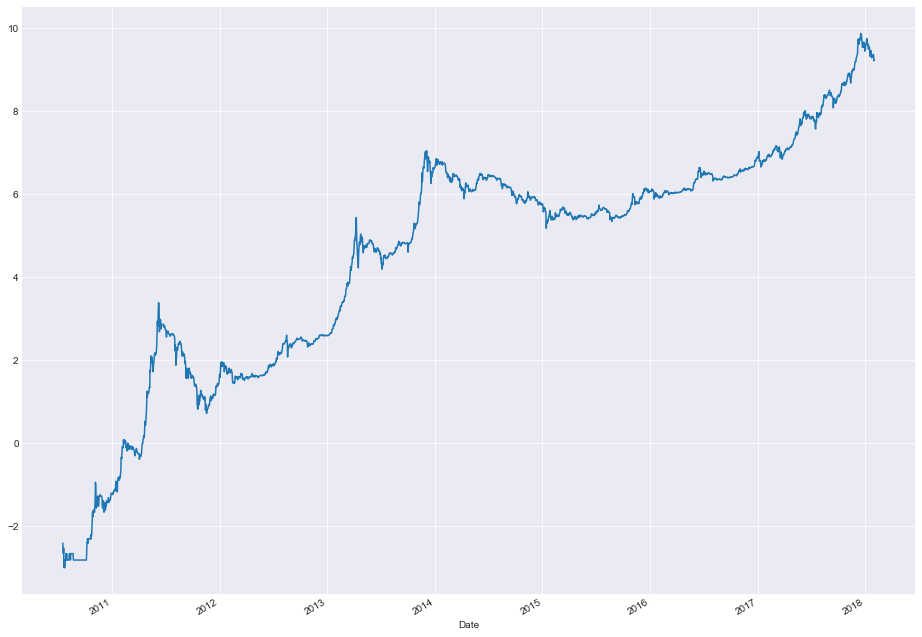

In [7]:
coinbase['Natural Log'] = coinbase['Close Price'].apply(lambda x: np.log(x))
coinbase['Natural Log'].plot(figsize=(12,10))

In [8]:
coinbase['Original Variance'] = pd.rolling_var(coinbase['Close Price'], 30, min_periods=None, freq=None, center=True)  
coinbase['Log Variance'] = pd.rolling_var(coinbase['Natural Log'], 30, min_periods=None, freq=None, center=True)

C:\Users\William\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=True).var()
  """Entry point for launching an IPython kernel.
C:\Users\William\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=True).var()
  


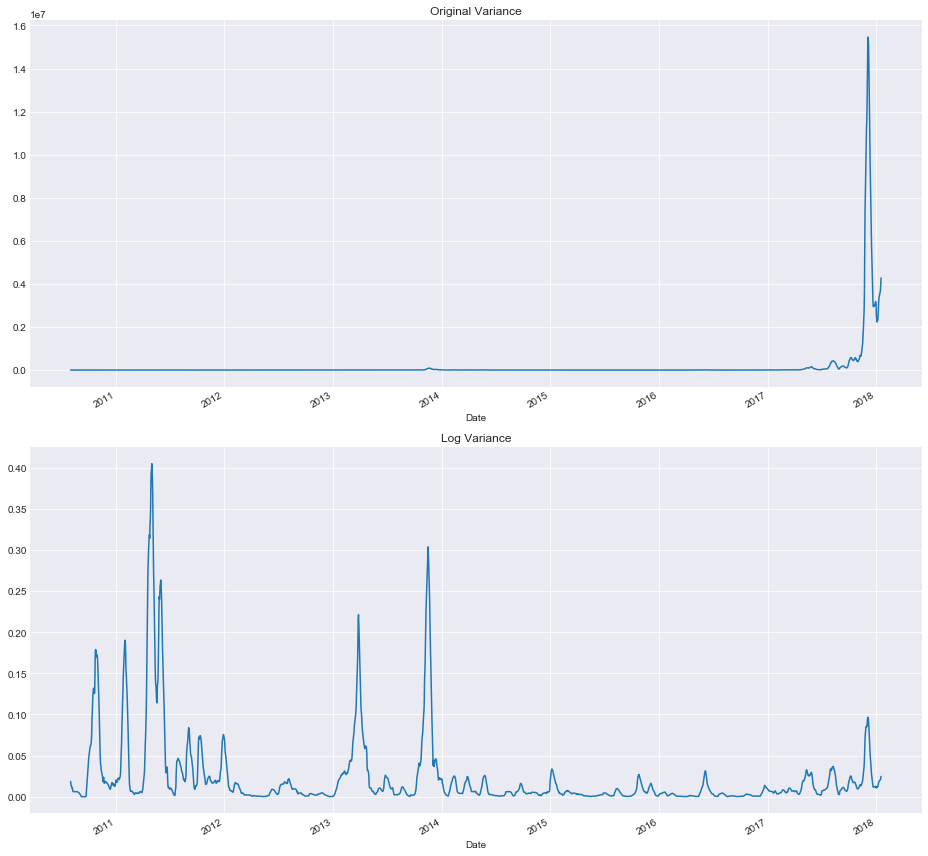

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))  
coinbase['Original Variance'].plot(ax=ax[0], title='Original Variance')  
coinbase['Log Variance'].plot(ax=ax[1], title='Log Variance')  
fig.tight_layout()  

Above shows that changes are much easier to see despite their magnitude

Get stationary data of logged data

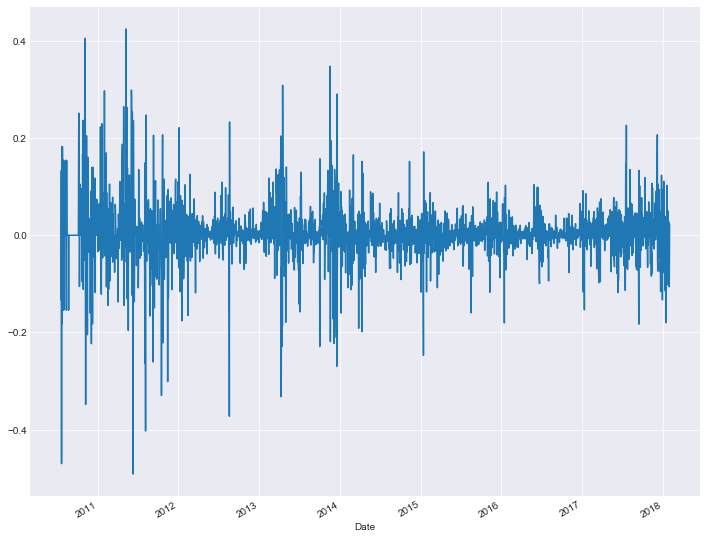

In [10]:
coinbase['Logged First Difference'] = coinbase['Natural Log'] - coinbase['Natural Log'].shift()
coinbase['Logged First Difference'].plot(figsize=(12,10))

Data is now stationary

Create time lag variables

In [11]:
# Daily Lag
coinbase['Lag 1'] = coinbase['Logged First Difference'].shift()
# Weekly Lag
coinbase['Lag 5'] = coinbase['Logged First Difference'].shift(5)

Joint plots with lag variables vs logged first difference

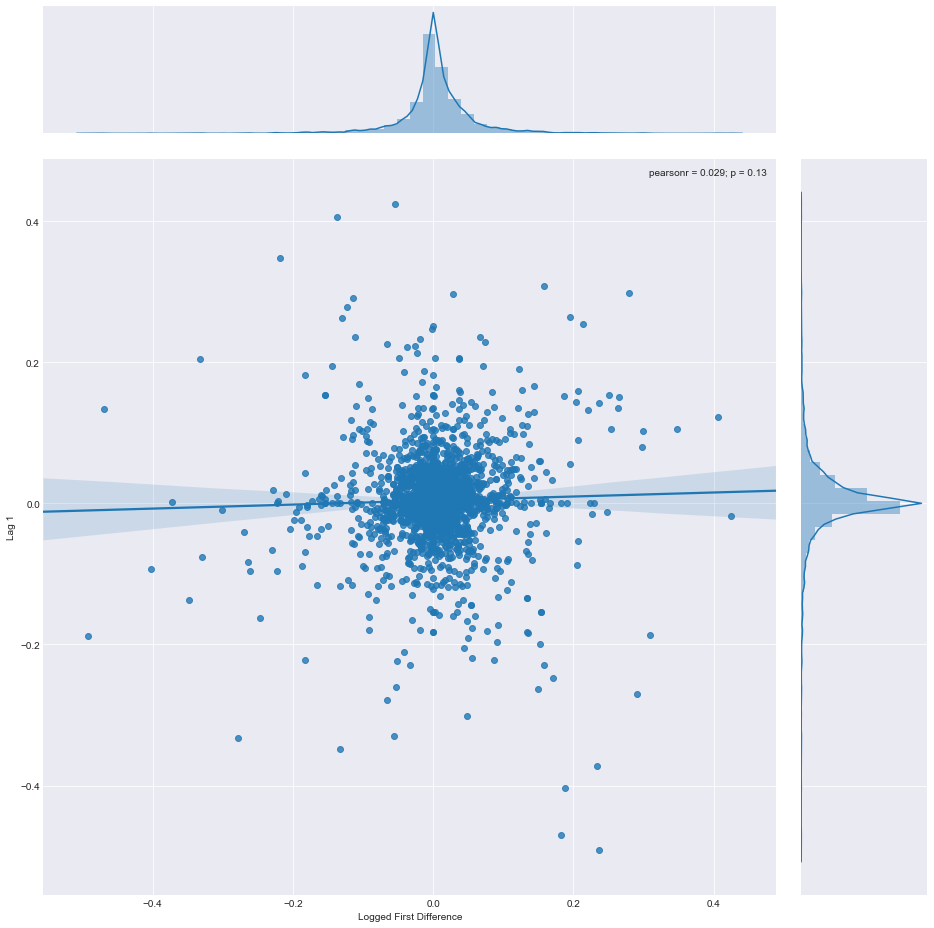

In [12]:
sb.jointplot('Logged First Difference', 'Lag 1', coinbase, kind='reg', size=11)

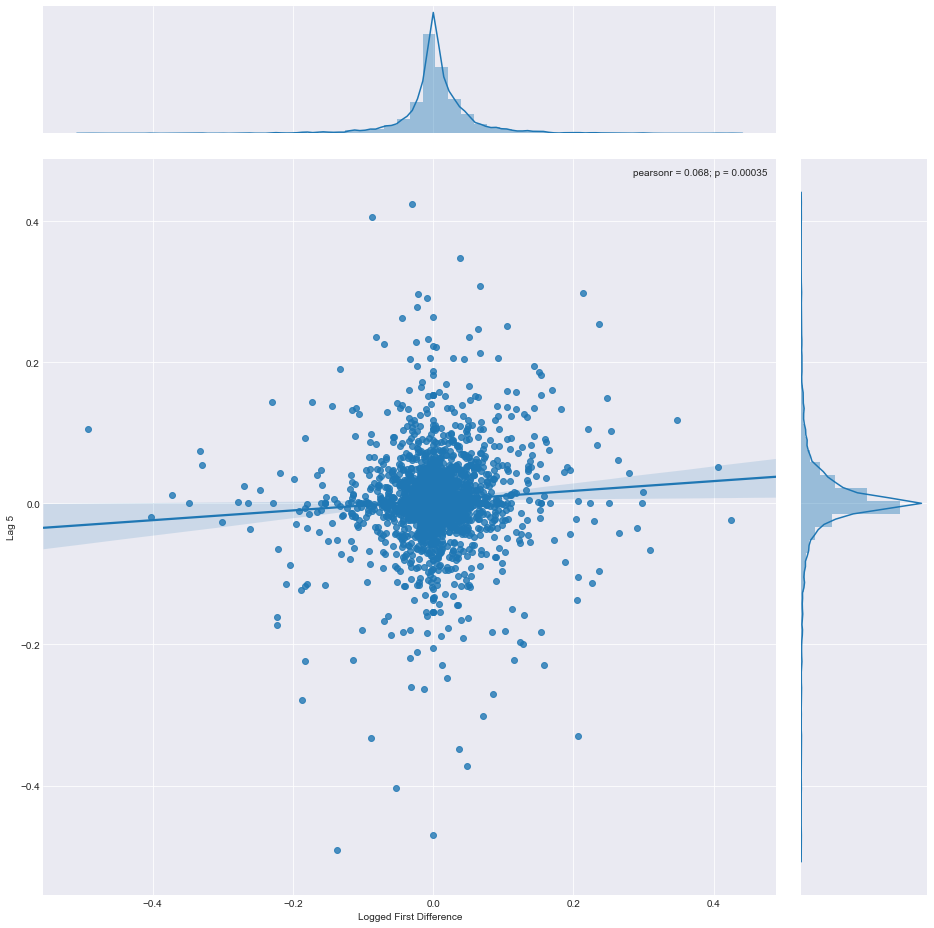

In [13]:
sb.jointplot('Logged First Difference', 'Lag 5', coinbase, kind='reg', size=11)

Being zero-centered and a normal-ish distribution, not much correlation between daily or weekly prices to the current price

Run acf/pacf to do this automatically

In [14]:
coinbase = coinbase.drop('NaT')

In [15]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

In [16]:
lag_correlations = acf(coinbase['Logged First Difference'].iloc[1:])  
lag_partial_correlations = pacf(coinbase['Logged First Difference'].iloc[1:])  

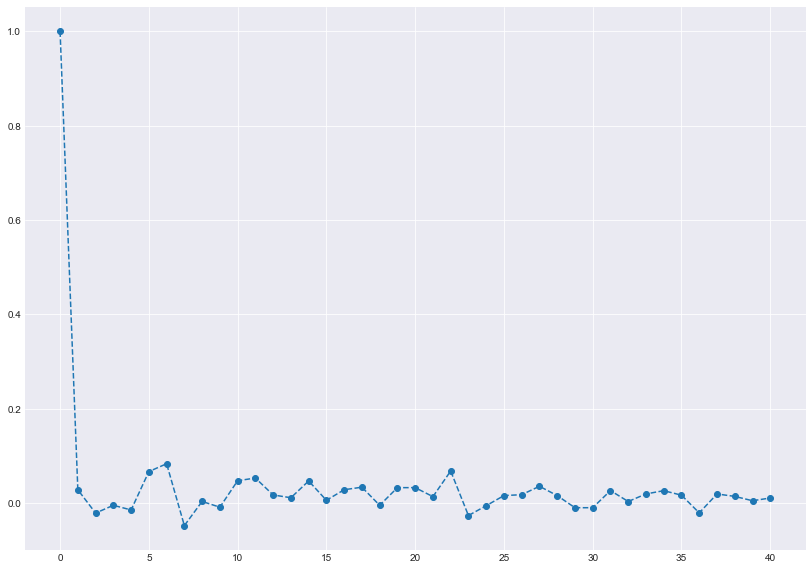

In [17]:
fig, ax = plt.subplots(figsize=(12,10))  
ax.plot(lag_correlations, marker='o', linestyle='--')  

Results show that past history doesn't help much to predict current prices

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [19]:
decomposition = seasonal_decompose(coinbase['Natural Log'], model='additive', freq=30)

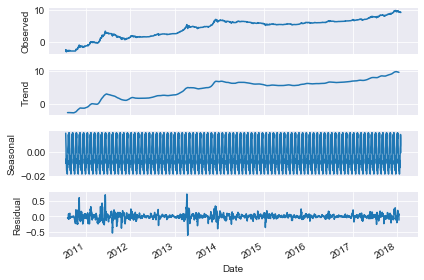

In [20]:
fig = plt.figure()  
fig = decomposition.plot() 

No clear cycle in prices

C:\Users\William\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\William\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\William\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


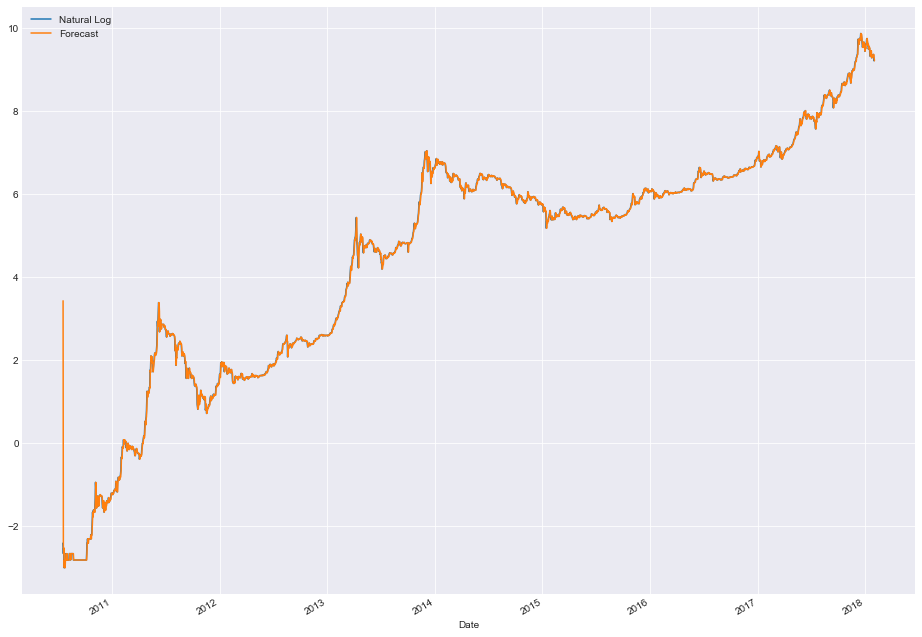

In [21]:
model = sm.tsa.ARIMA(coinbase['Natural Log'].iloc[1:], order=(1, 0, 0))  
results = model.fit(disp=-1)  
coinbase['Forecast'] = results.fittedvalues  
coinbase[['Natural Log', 'Forecast']].plot(figsize=(12, 10))  

So an ARIMA model run with an undifferenced model is so accurate it almost overlaps

What about applying an 'I' term? Namely that of a (1,1,0) ARIMA model. 
ie. differenced-first-order autoregressive model

C:\Users\William\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\William\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\William\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


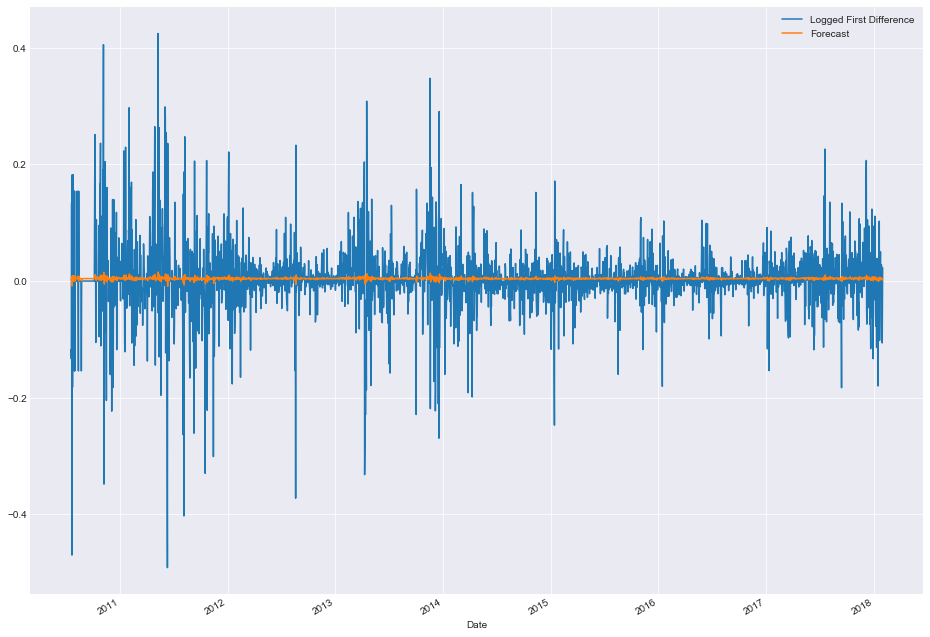

In [22]:
model = sm.tsa.ARIMA(coinbase['Natural Log'].iloc[1:], order=(1, 1, 0))  
results = model.fit(disp=-1)  
coinbase['Forecast'] = results.fittedvalues  
coinbase[['Logged First Difference', 'Forecast']].plot(figsize=(12, 10))  

If we zoom in, poor predictions that barely move according to real changes

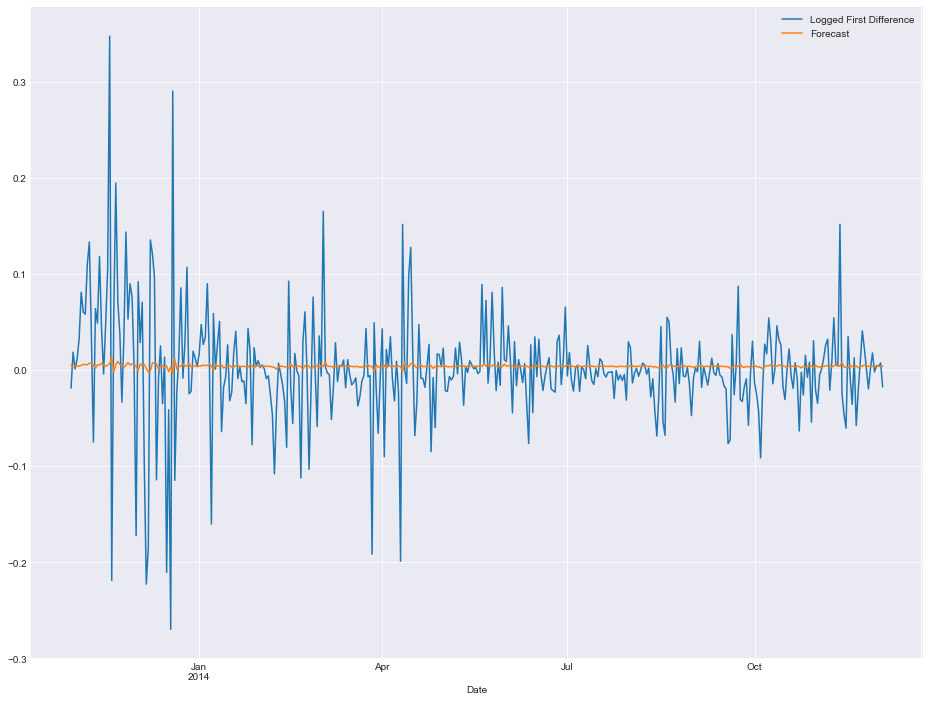

In [23]:
coinbase[['Logged First Difference', 'Forecast']].iloc[1200:1600, :].plot(figsize=(12, 10))  

Applying statistical / pure time series methods aren't very effective.  

So let's try an LSTM

In [24]:
import datetime
import time

# Machine Learning Analysis

In [25]:
bdata = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20150101&end="+time.strftime("%Y%m%d"))[0]

Data that starts from the beginning of 2015 to the current date

In [26]:
bdata = bdata.assign(Date=pd.to_datetime(bdata['Date']))
bdata['Volume'] = bdata['Volume'].astype('int64')

Let's add: <br/>
    1) Close off High: The gap between the close and high.  <br/>
        -1 means that the close was equal to the low, 1 means close to the high <br/>
    2) Volatility<br/>
        

In [27]:
kwargs = {
            'Close Off High': lambda x: 2*(x['High'] - x['Close'])/(x['High'] - x['Low'])-1,
             'Volatility': lambda x: (x['High'] - x['Low'])/(x['Open'])
         }

In [28]:
bdata = bdata.assign(**kwargs)
bdata.head()

,Date,Open,High,Low,Close,Volume,Market Cap,Close Off High,Volatility
0,2018-01-30,11306.8,11307.2,10036.2,10106.3,8637860000,190339000000,0.889693,0.112410
1,2018-01-29,11755.5,11875.6,11179.2,11296.4,7107360000,197871000000,0.663412,0.059240
2,2018-01-28,11475.3,12040.3,11475.3,11786.3,8350360000,193133000000,-0.100885,0.049236
3,2018-01-27,11174.9,11614.9,10989.2,11440.7,7583270000,188054000000,-0.443184,0.055992
4,2018-01-26,11256.0,11656.7,10470.3,11171.4,9746200000,189398000000,-0.181895,0.105402


In [29]:
# Get only relevant columns
mdata = bdata[['Date']+['Close']+['Volume']+['Close Off High']+['Volatility']]
mdata = mdata.sort_values(by='Date')
mdata.head()

,Date,Close,Volume,Close Off High,Volatility
1125,2015-01-01,314.25,8036550,0.922360,0.020097
1124,2015-01-02,315.03,7860650,-0.289474,0.007259
1123,2015-01-03,281.08,33054400,1.000000,0.108210
1122,2015-01-04,264.19,55629100,0.555706,0.105353
1121,2015-01-05,274.47,43962800,-0.416290,0.050023


Use all data before 1/1/2017 for training, after for test

In [30]:
split_date = '2017-07-01'
training_set, test_set = mdata[mdata['Date']<split_date], mdata[mdata['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [31]:
training_set.head()

,Close,Volume,Close Off High,Volatility
1125,314.25,8036550,0.922360,0.020097
1124,315.03,7860650,-0.289474,0.007259
1123,281.08,33054400,1.000000,0.108210
1122,264.19,55629100,0.555706,0.105353
1121,274.47,43962800,-0.416290,0.050023


In [32]:
window_len=10
norm_cols= ['Close', 'Volume']

In [33]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

Output is next price normalized to 10th previous closing price

In [34]:
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

In [35]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)

In [36]:
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

Normalized Close and Volume columns, because NNs don't like big numbers

In [37]:
LSTM_training_inputs[0]

,Close,Volume,Close Off High,Volatility
1125,0.000000,0.000000,0.922360,0.020097
1124,0.002482,-0.021888,-0.289474,0.007259
1123,-0.105553,3.113009,1.000000,0.108210
1122,-0.159300,5.922013,0.555706,0.105353
1121,-0.126587,4.470357,-0.416290,0.050023
1120,-0.089292,1.892497,-0.816835,0.054077
1119,-0.063357,2.094213,-0.437141,0.054775
1118,-0.098329,1.486453,0.804184,0.040628
1117,-0.075863,1.329184,-0.867675,0.037467
1116,-0.125537,0.899360,0.882768,0.049286


In [39]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [40]:
import tensorflow as tf

In [41]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [48]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12639607075037201389
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 45062553
locality {
  bus_id: 1
}
incarnation: 12165288944667542282
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [42]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

build_model makes an empty model to which an LSTM layer is added. 

The layer is shaped to fit inputs

In [45]:
np.random.seed(69)
btc_model = build_model(LSTM_training_inputs, output_size=1, neurons=20)
btc_history = btc_model.fit(LSTM_training_inputs, LSTM_training_outputs, epochs=50, batch_size=64, verbose=1, shuffle=True)

Epoch 1/50
902/902 [==============================] - 1s 1ms/step - loss: 0.1623
Epoch 2/50
902/902 [==============================] - 0s 381us/step - loss: 0.1232
Epoch 3/50
902/902 [==============================] - 0s 294us/step - loss: 0.0950
Epoch 4/50
902/902 [==============================] - 0s 312us/step - loss: 0.0833
Epoch 5/50
902/902 [==============================] - 0s 295us/step - loss: 0.0710
Epoch 6/50
902/902 [==============================] - 0s 294us/step - loss: 0.0659
Epoch 7/50
902/902 [==============================] - 0s 346us/step - loss: 0.0581
Epoch 8/50
902/902 [==============================] - 0s 277us/step - loss: 0.0553
Epoch 9/50
902/902 [==============================] - 0s 312us/step - loss: 0.0522
Epoch 10/50
902/902 [==============================] - 0s 295us/step - loss: 0.0500
Epoch 11/50
902/902 [==============================] - 0s 329us/step - loss: 0.0452
Epoch 12/50
902/902 [==============================] - 0s 329us/step - loss: 0.0441
Epo

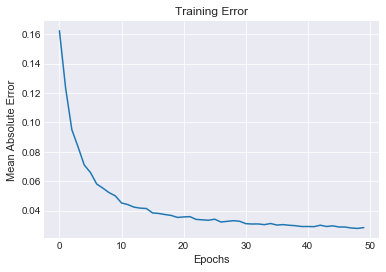

In [46]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(btc_history.epoch, btc_history.history['loss'])
ax1.set_title('Training Error')

ax1.set_ylabel('Mean Absolute Error', fontsize=11)
ax1.set_xlabel('Epochs', fontsize=11)
plt.show()

Since the training error decreases over time, everything's good up to now